# Libraries

In [2]:
#  /data/hodges_lab/Tim/.conda/envs/jupyter_modality/lib/python3.11/site-packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyranges as pr
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import xarray as xr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import pysam
import os
os.environ["DS_BUCKET_CACHE"]="/data/hodges_lab/Tim/biomodal/tmp/"
import math
import matplotlib as mpl
# modality
import modality
from modality.contig_dataset import ContigDataset
from modality.annotation import get_tss_region
# warnings
import warnings
warnings.filterwarnings(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]

print("Loaded.")

2024-06-20 14:39:08 | INFO | [/data/hodges_lab/Tim/.conda/envs/jupyter_modality/lib/python3.11/site-packages/modality/read_locally.py:20] Setting cache dir as /data/hodges_lab/Tim/biomodal/tmp/. To modify alter the DS_BUCKET_CACHE environment variable
Loaded.


# Load 6-base duet evoC data

In [3]:
## Load 6-base duet evoC data
sixbase_path = "/data/hodges_lab/Tim/biomodal/data/Hodges_2024_02_CG.zarrz"
ds = ContigDataset.from_zarrz(sixbase_path)

# Load region file

In [4]:
dir_regions="/data/hodges_lab/Tim/biomodal/data/ensembl/"

## Shuffled regions

In [5]:
# set groups to iterate through 
# note: the files were set up to have a common name, except for groupnames to iterate
sets=['enhancer','promoter']

In [6]:
# create a dictionary to keep track of input BED files
beds={}

# load in BED files to the dictionary
for i in sets:
    beds[i]=pr.readers.read_bed(dir_regions + "ENSEMBL.GRCh38.v112.regulatory_features."+str(i)+".bed")

# Center bed files

## Function def

In [7]:
## center_bed_coord
## Purpose: Take in a pyranges bed file and centers the start and end coordinates
##          to represent one base pair
## Takes: PyRanges object
## Returns: PyRanges object
## E.g.: chr1  100  200  -->  chr1  150 151
def center_bed_coord(input_bed, offset):
    # make copy of input PyRanges as df
    input_bed_df=input_bed.df
    # find start
    input_bed_df['Start']=np.floor((input_bed.df['Start']+input_bed.df['End']) / 2).astype(int)-offset
    # find end
    input_bed_df['End'] = (np.floor((input_bed.df['Start']+input_bed.df['End']) / 2)).astype(int)+offset
    # convert to PyRanges object
    input_bed_pr=pr.PyRanges(input_bed_df)
    # return PyRanges object
    return(input_bed_pr)

## center

In [8]:
# create empty dictionary to keep track of centered BEDs
beds250={}
offset_val=250

# center
for i in sets:
    beds250[i]=center_bed_coord(beds[i], offset_val)

# Map ATAC_6base data

## Function def

In [9]:
## Written by Biomodal
def get_atac_6base_over_tss(time, ds, tss_pr):

    # select sample for the timepoint
    if time == 0:
        sample = "10274-AJ-0289"
        atac_time = "0hr"
    elif time == 4:
        sample = "10274-AJ-0290"
        atac_time = "108hr"
    elif time == 8:
        sample = "10274-AJ-0291"
        atac_time = "12day"

    print("Getting 6-base data for sample: " + sample)
    ds = ds.select_samples([sample])
    
    ds = ds.assign_fractions(
        numerators=["num_modc", "num_mc", "num_hmc"],
        denominator="num_total_c", 
        min_coverage=10
    )

    # load ATAC_seq data
    atac_path = "/data/hodges_lab/Tim/biomodal/data/bedgraphs/NPCdiffATACme" + atac_time + "_merge_filtered.bedGraph"
    print("Loading ATAC-seq data from: " + atac_path)
    atac = pd.read_csv(atac_path, sep = "\t",
                       names=['Chromosome', 'Start', 'End', 'Accessibility'])
    
    contigs = ["chr" + str(x) for x in list(range(1,23)) + ["X", "Y"]]
    atac = atac[atac.Chromosome.isin(contigs)]
    atac.Chromosome = pd.Categorical(atac.Chromosome)
    atac.Start = atac.Start.astype(int)
    atac.End = atac.End.astype(int)
    atac.Accessibility = atac.Accessibility.astype(float)
    atac['End'] = atac['End'] - 1
    # make as pyranges
    atac_pr = pr.PyRanges(atac)

    print("Overlapping ATAC-seq data with TSS regions.")
    # find atac-regions that overlap tss
    accessib = atac_pr.intersect(tss_pr)
    # assign id to the overlapping regions
    # if less than 1 bp apart, assign the same id
    r = accessib.cluster(slack=1)
    # add length of regions
    r.Length = r.lengths()
    # group by clusters
    g = r.df.groupby('Cluster')

    # start and end coordinates for each cluster is now a TSS
    # for each region, get the mean accessibility, weighted by the length of the region
    result = pr.from_dict(
            {
                "Chromosome": g.Chromosome.first(),
                "Start": g.Start.min(),
                "End": g.End.max(),
                "accessibility": g.apply(collapse, 'Accessibility'),
            }
        )
    
    # join with tss data
    joined_list = result.join(tss_pr)
    atac_over_tss = joined_list
    atac_over_tss = atac_over_tss.drop_duplicate_positions().sort().copy()
    
    # update Range ID
    atac_over_tss.Ranges_ID = list(range(len(atac_over_tss)))
    
    # summarise 6-base data for all TSS regions
    print("Summarising 6-base data over TSS regions.")
    sixbase_over_tss = []
    
    for mod in ["mc", "hmc", "modc"]:
        print(mod)
    
        for offset_val in (-1000, -500, 0, 500, 1000):
            
            qq = atac_over_tss.apply(offset, offset=offset_val).unstrand()
                    
            y = ds.reduce_byranges(
                ranges=qq[["Chromosome", "Start", "End", "Ranges_ID"]],
                var=[f'frac_{mod}', f'num_{mod}'],
                min_count=1,
                # min_count is the minimum number of data entries required in each interval of range to calculate mean
                # we could adjust this to 3 or so
            )
    
            # also add num_contexts and range_length as data_vars
            y = y.reset_coords(['num_contexts', 'range_length'])
            
            mapper = {c: f"{c}_{offset_val}" for c in y.data_vars}
            y = y.rename_vars(mapper)
            
            sixbase_over_tss.append(y)
            
            #print(offset_val, mod)
            
    # create data frame with summarised 6-base data over TSS
    sixbase_over_tss_results = xr.merge(sixbase_over_tss, compat = 'override')
    sixbase_over_tss_df = sixbase_over_tss_results.to_dataframe().droplevel(1)
    sixbase_over_tss_df = sixbase_over_tss_df.drop(["contig", "start", "end"], axis=1)

    # add atac data to df
    result_df = atac_over_tss.df.copy()
    result_df = result_df.set_index("Ranges_ID")
    result_df = result_df.join(sixbase_over_tss_df)
    # not including TSS with accessibility = 0 at this stage
    # TODO: identify "true" regions with 0 accessibility using coverage from WGS data?
    result_df['log_accessibility'] = [np.log(x) if x > 0 else np.nan for x in result_df.accessibility.values]
    return(result_df)
    

# for each region, get the mean accessibility, weighted by the length of the region
def collapse(df, val):
    x = np.average(df[val], weights = df.Length)
    return x


def offset(df, **kwargs):
    df_copy = df.copy()
    df_copy.loc[:, "End"] = kwargs["offset"] + df_copy.End
    df_copy.loc[:, "Start"] = kwargs["offset"] + df_copy.Start
    return df_copy

## map

In [10]:
beds250_m0={}
beds250_m4={}
beds250_m8={}

for i in sets:
    print('-------------     Mapping: '+i+'     -------------')
    beds250_m0[i]=get_atac_6base_over_tss(time = 0,
                                          ds = ds,
                                          tss_pr = beds250[i])
    beds250_m4[i]=get_atac_6base_over_tss(time = 4,
                                          ds = ds,
                                          tss_pr = beds250[i])
    beds250_m8[i]=get_atac_6base_over_tss(time = 8,
                                          ds = ds,
                                          tss_pr = beds250[i])

-------------     Mapping: enhancer     -------------
Getting 6-base data for sample: 10274-AJ-0289
Loading ATAC-seq data from: /data/hodges_lab/Tim/biomodal/data/bedgraphs/NPCdiffATACme0hr_merge_filtered.bedGraph
Overlapping ATAC-seq data with TSS regions.
Summarising 6-base data over TSS regions.
mc
hmc
modc
Getting 6-base data for sample: 10274-AJ-0290
Loading ATAC-seq data from: /data/hodges_lab/Tim/biomodal/data/bedgraphs/NPCdiffATACme108hr_merge_filtered.bedGraph
Overlapping ATAC-seq data with TSS regions.
Summarising 6-base data over TSS regions.
mc
hmc
modc
Getting 6-base data for sample: 10274-AJ-0291
Loading ATAC-seq data from: /data/hodges_lab/Tim/biomodal/data/bedgraphs/NPCdiffATACme12day_merge_filtered.bedGraph
Overlapping ATAC-seq data with TSS regions.
Summarising 6-base data over TSS regions.
mc
hmc
modc
-------------     Mapping: promoter     -------------
Getting 6-base data for sample: 10274-AJ-0289
Loading ATAC-seq data from: /data/hodges_lab/Tim/biomodal/data/bedgr

## save mapped dictionaries

In [11]:
# Mapped on 0
np.save('/data/hodges_lab/Tim/biomodal/mapped_python_objects/enhancer_vs_promoter.mchmc_mc_hmc.x_timepoint.beds250_m0.npy', beds250_m0) 

# Mapped on 4 day
np.save('/data/hodges_lab/Tim/biomodal/mapped_python_objects/enhancer_vs_promoter.mchmc_mc_hmc.x_timepoint.beds250_m4.npy', beds250_m4) 

# Mapped on 8 day
np.save('/data/hodges_lab/Tim/biomodal/mapped_python_objects/enhancer_vs_promoter.mchmc_mc_hmc.x_timepoint.beds250_m8.npy', beds250_m8) 

In [ ]:
read_dictionary = np.load('my_file.npy',allow_pickle='TRUE').item()

In [ ]:
beds250_m0_load = np.load('/data/hodges_lab/Tim/biomodal/mapped_python_objects/enhancer_vs_promoter.mchmc_mc_hmc.x_timepoint.beds250_m0.npy',allow_pickle='TRUE').item()

beds250_m4_load = np.load('/data/hodges_lab/Tim/biomodal/mapped_python_objects/enhancer_vs_promoter.mchmc_mc_hmc.x_timepoint.beds250_m4.npy',allow_pickle='TRUE').item()

beds250_m8_load = np.load('/data/hodges_lab/Tim/biomodal/mapped_python_objects/enhancer_vs_promoter.mchmc_mc_hmc.x_timepoint.beds250_m8.npy',allow_pickle='TRUE').item()

# Train/Predict

## Helper function def

In [16]:
## Written by Biomodal

def eval_results(test_obs, pred_obs):
    mse = mean_squared_error(test_obs, pred_obs)
    r2 = r2_score(test_obs, pred_obs)
    spear = spearmanr(test_obs, pred_obs).correlation
    pears = pearsonr(test_obs, pred_obs).statistic

    return {"mse": mse, "r2": r2, "pearsonR": pears, "spearmanR": spear}




def find_optimal_parameters(res_train, mod="mc + hmc", test_contig="chr1"):

    X = res_train.loc[res_train.accessibility > 0]
    X_train = X[X.Chromosome != test_contig]
    y_train = X_train['log_accessibility']

    # select predictors to use in model
    if (mod == "modc") | (mod == "mc"):
        predictors = ["frac_" + mod + "_mean_" + str(x) for x in [-1000,-500,0,500,1000]]
        predictors += ["num_contexts_" + str(x) for x in [-1000,-500,0,500,1000]]
    elif mod == "mc + hmc":
        predictors = ["frac_mc" + "_mean_" + str(x) for x in [-1000,-500,0,500,1000]]
        predictors += ["frac_hmc" + "_mean_" + str(x) for x in [-1000,-500,0,500,1000]]
        predictors += ["num_contexts_" + str(x) for x in [-1000,-500,0,500,1000]]
    
#     param_grid = {
#         "n_estimators": [500],
#         "max_depth": [7],
#         "eta": [0.01],
#         "subsample": np.arange(0.5, 0.6, 0.1),
#         "colsample_bytree": [0.8],
#     }
    
    param_grid = {
        "n_estimators": np.arange(100, 600, 200), # 100|300|500
        "max_depth": np.arange(3, 8, 2), # 3|5|7
        "eta": np.arange(0.01, 0.05, 0.01), # 0.01|0.02|0.03|0.04|0.05
        "subsample": np.arange(0.2, 0.6, 0.1), # 0.2|.3|.4|.5|.6 
        "colsample_bytree": np.arange(0.8, 1.0, 0.05), # 0.8|0.85|0.9|0.95
    }
    
    #{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.5000000000000001}
    
    print("Finding optimal parameters for: " + mod)
    regressor = xgb.XGBRegressor(eval_metric="rmsle")
    search = GridSearchCV(regressor, param_grid, cv=3).fit(X_train[predictors], y_train)
    print("Optimal parameters for " + mod + ":")
    print(search.best_params_)

## Function def

In [37]:
## Written by Biomodal
## Editted by Tim Scott
def predict_accessibility_from_timepoint(res_train, res_test, t1, t2, test_contig = "chr1", main_title ="", graphs=False, **kwargs): # save_pdf = False, filename = None
    # Edited TS

    # Set training and testing data - one chromosome as outgroup
    X_train = res_train.loc[res_train.accessibility > 0]
    X_test = res_test.loc[res_test.accessibility > 0]
    X_train = X_train[X_train.Chromosome != test_contig]
    X_test = X_test[X_test.Chromosome == test_contig]
    y_train = X_train['log_accessibility']
    y_test = X_test['log_accessibility']
    
    
    # Initialize lists array for print reporting
    mse=["Mean Sq Err:"]
    rsquared=["R-squared:"]
    pearson=["Pearson's r:"]
    spearman=["Spearman's r:"]
    regressors={}
    if graphs:
        fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    for mod, ax in zip(["modc", "mc", "mc + hmc", "hmc"], axes.ravel()):
    
        # Select predictors to use in model - store in list
        if (mod == "modc") | (mod == "mc") | (mod=="hmc"):
            predictors = ["frac_" + mod + "_mean_" + str(x) for x in [-1000,-500,0,500,1000]]
            predictors += ["num_contexts_" + str(x) for x in [-1000,-500,0,500,1000]]
        elif mod == "mc + hmc":
            predictors = ["frac_mc" + "_mean_" + str(x) for x in [-1000,-500,0,500,1000]]
            predictors += ["frac_hmc" + "_mean_" + str(x) for x in [-1000,-500,0,500,1000]]
            predictors += ["num_contexts_" + str(x) for x in [-1000,-500,0,500,1000]]
        #print(predictors)
        
        
        # Fit the model to the training data using predictors
        # parameters optimal for day 8 mc+hmc model
        regressor_sixbase = xgb.XGBRegressor(
            n_estimators=kwargs.get('n_estimators', 500), # 500
            max_depth=kwargs.get('max_depth', 7), # 7
            eta=kwargs.get('eta', 0.01), # 0.01
            subsample=kwargs.get('subsample', 0.5), # 0.5
            colsample_bytree=kwargs.get('colsample_bytree', 0.8), # 0.8
        )
        # Fit
        regressor_sixbase.fit(X_train[predictors], y_train)
        
        
        # Predict
        y_pred_sixbase = regressor_sixbase.predict(X_test[predictors])
        
        
        # Eval results
        out = eval_results(y_test, y_pred_sixbase)
        mse.append(str(round(out['mse'],4)))
        rsquared.append(str(round(out['r2'],4)))
        pearson.append(str(round(out['pearsonR'],4)))
        spearman.append(str(round(out['spearmanR'],4)))
        # Record spearman in spearman_dictionary object
        if(mod=="mc"):
            spears["mc_"+str(t1)+str(t2)]=str(round(out['spearmanR'],4))
        if(mod=="mc + hmc"):
            spears["mchmc_"+str(t1)+str(t2)]=str(round(out['spearmanR'],4))
        if(mod=="hmc"):
            spears["hmc_"+str(t1)+str(t2)]=str(round(out['spearmanR'],4))
        regressors[mod]=regressor_sixbase
    
        # Plot results
        if graphs:
            r2=out['r2']
            spear_r=out['spearmanR']  
            sns.scatterplot(x=y_pred_sixbase, y=y_test, color=biomodal_palette[0], s=50, ax=ax)
            sns.regplot(x=[min(y_pred_sixbase), max(y_pred_sixbase)], 
                        y=[min(y_pred_sixbase), max(y_pred_sixbase)],
                        ci=None,
                        line_kws={"color": biomodal_palette[2], "linestyle": '--'},
                        ax=ax)
            if(mod == "modc"):
                ax.set_ylabel("Observed log(Accessibility)", size=16)
            else:
                ax.set_ylabel("", size=16)
            ax.set_xlabel("Predicted log(Accessibility)", size=16)
            if mod == "mc + hmc":
                mod = "mC + hmC"
            else:
                mod = mod[:-1] + mod[-1].upper()           
            ax.set_title(f"{mod}: $R^2$={r2:.3f}, Spearman $r$={spear_r:.3f}", size=18)
            ax.tick_params(axis='both', which='major', labelsize=13)
            ax.grid(True)
            fig.suptitle(main_title, size=18)
            fig.tight_layout()
    
    if graphs:
        fig, axes = plt.subplots(1, 4, figsize=(18, 5))
        for mod, ax in zip(["modc", "mc", "mc + hmc", "hmc"], axes.ravel()):
            xgb.plot_importance(regressors[mod], max_num_features = 10, ax = ax)
            fig.suptitle(main_title, size=18)
            fig.tight_layout()

    # Print out results
    print(*["Results for:", "modC", "mC", "mC+hmC", "hmc"], sep='\t')
    print(*mse, sep='\t')
    print(*rsquared, sep='\t')
    print(*pearson, sep='\t')
    print(*spearman, sep='\t')

In [39]:
def predict_accessibility_from_timepoint(res_train, res_test, t1, t2, test_contig = "chr8", main_title ="", graphs=False, **kwargs): # save_pdf = False, filename = None
    # Edited TS

    
    # Split test/train for res_train
    # Accessibility > 0 | Split 90/10, keep 90 for training
    X_train_df = res_train.loc[res_train.accessibility > 0]
    y_train_vals = X_train_df['log_accessibility']
    X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_vals,
                                                              random_state=100, test_size=0.1)
    # Split test/train for res_test - if other time for testing
    # Accessibility > 0 | Split 90/10, keep 90 for training
    if (t1!=t2):
        X_test_df = res_test.loc[res_test.accessibility > 0]
        y_test_vals = X_test_df['log_accessibility']
        X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X_test_df, y_test_vals, random_state=100, test_size=0.1)
        # Set final vars for testing
        X_test=X_test_two
        y_test=y_test_two

    
    
    # Initialize lists array for print reporting
    mse=["Mean Sq Err:"]
    rsquared=["R-squared:"]
    pearson=["Pearson's r:"]
    spearman=["Spearman's r:"]
    regressors={}
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    for mod, ax in zip(["modc", "mc", "mc + hmc", "hmc"], axes.ravel()):
        # Initialize keys for dictionary if not existing
        if "mc_"+str(t1)+str(t2) not in spears:
            spears["mc_"+str(t1)+str(t2)]=[]
        if "mchmc_"+str(t1)+str(t2) not in spears:
            spears["mchmc_"+str(t1)+str(t2)]=[]
        if "hmc_"+str(t1)+str(t2) not in spears:
            spears["hmc_"+str(t1)+str(t2)]=[]
            
        
        # Select predictors to use in model - store in list
        if (mod == "modc") | (mod == "mc") | (mod=="hmc"):
            predictors = ["frac_" + mod + "_mean_" + str(x) for x in [-1000,-500,0,500,1000]]
            predictors += ["num_contexts_" + str(x) for x in [-1000,-500,0,500,1000]]
        elif mod == "mc + hmc":
            predictors = ["frac_mc" + "_mean_" + str(x) for x in [-1000,-500,0,500,1000]]
            predictors += ["frac_hmc" + "_mean_" + str(x) for x in [-1000,-500,0,500,1000]]
            predictors += ["num_contexts_" + str(x) for x in [-1000,-500,0,500,1000]]
        #print(predictors)
        
        
        # Fit the model to the training data using predictors
        # parameters optimal for day 8 mc+hmc model
        regressor_sixbase = xgb.XGBRegressor(
            n_estimators=kwargs.get('n_estimators', 500), # 500
            max_depth=kwargs.get('max_depth', 7), # 7
            eta=kwargs.get('eta', 0.01), # 0.01
            subsample=kwargs.get('subsample', 0.5), # 0.5
            colsample_bytree=kwargs.get('colsample_bytree', 0.8), # 0.8
        )
        # Fit
        regressor_sixbase.fit(X_train[predictors], y_train)
        
        
        # Predict
        y_pred_sixbase = regressor_sixbase.predict(X_test[predictors])
        
        
        # Eval results
        out = eval_results(y_test, y_pred_sixbase)
        mse.append(str(round(out['mse'],4)))
        rsquared.append(str(round(out['r2'],4)))
        pearson.append(str(round(out['pearsonR'],4)))
        spearman.append(str(round(out['spearmanR'],4)))
        # Record spearman in spearman_dictionary object
        if(mod=="mc"):
            spears["mc_"+str(t1)+str(t2)].append(str(round(out['spearmanR'],4)))
        if(mod=="mc + hmc"):
            spears["mchmc_"+str(t1)+str(t2)].append(str(round(out['spearmanR'],4)))
        if(mod=="hmc"):
            spears["hmc_"+str(t1)+str(t2)].append(str(round(out['spearmanR'],4)))
        regressors[mod]=regressor_sixbase
    
        # Plot results
        if graphs:
            r2=out['r2']
            spear_r=out['spearmanR']  
            sns.scatterplot(x=y_pred_sixbase, y=y_test, color=biomodal_palette[0], s=50, ax=ax)
            sns.regplot(x=[min(y_pred_sixbase), max(y_pred_sixbase)], 
                        y=[min(y_pred_sixbase), max(y_pred_sixbase)],
                        ci=None,
                        line_kws={"color": biomodal_palette[2], "linestyle": '--'},
                        ax=ax)
            if(mod == "modc"):
                ax.set_ylabel("Observed log(Accessibility)", size=16)
            else:
                ax.set_ylabel("", size=16)
            ax.set_xlabel("Predicted log(Accessibility)", size=16)
            if mod == "mc + hmc":
                mod = "mC + hmC"
            else:
                mod = mod[:-1] + mod[-1].upper()           
            ax.set_title(f"{mod}: $R^2$={r2:.3f}, Spearman $r$={spear_r:.3f}", size=18)
            ax.tick_params(axis='both', which='major', labelsize=13)
            ax.grid(True)
            fig.suptitle(main_title, size=18)
            fig.tight_layout()
    
    if graphs:
        fig, axes = plt.subplots(1, 4, figsize=(18, 5))
        for mod, ax in zip(["modc", "mc", "mc + hmc", "hmc"], axes.ravel()):
            xgb.plot_importance(regressors[mod], max_num_features = 10, ax = ax)
            fig.suptitle(main_title, size=18)
            fig.tight_layout()

    # Print out results
    print(*["Results for:", "modC", "mC", "mC+hmC", "hmc"], sep='\t')
    print(*mse, sep='\t')
    print(*rsquared, sep='\t')
    print(*pearson, sep='\t')
    print(*spearman, sep='\t')

## Find optimal parameters

In [ ]:
# Find optimal parameters for day 0 - day 0 mc+hmc
find_optimal_parameters(res_train=beds250_m0['enhancer'])

In [ ]:
# Find optimal parameters for day 0 - day 0 mc+hmc
find_optimal_parameters(res_train=beds250_m0['promoter'])

In [ ]:
# Find optimal parameters for day 8 mc+hmc
find_optimal_parameters(res_train=beds250_m8['enhancer'])

In [ ]:
# Find optimal parameters for day 8 mc+hmc
find_optimal_parameters(res_train=beds250_m8['promoter'])

## train/predict

### spearman dictionary

In [36]:
# Initialize a spearman_dictionary to record spearman values
spears={}

### Trained on 0 hr



Predict - 0 hr
enhancer
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.6444	0.6174	0.5772	0.6878
R-squared:	0.2483	0.2798	0.3267	0.1977
Pearson's r:	0.4986	0.5292	0.5718	0.4447
Spearman's r:	0.3949	0.439	0.5073	0.4426
promoter
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.6318	0.6208	0.5932	0.8072
R-squared:	0.6893	0.6947	0.7083	0.603
Pearson's r:	0.8304	0.8337	0.8418	0.7768
Spearman's r:	0.8176	0.8254	0.8408	0.7769


Predict - 4 days
enhancer
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.6421	0.6307	0.6339	0.8073
R-squared:	0.259	0.2722	0.2685	0.0684
Pearson's r:	0.5698	0.6034	0.6316	0.4536
Spearman's r:	0.4436	0.4895	0.549	0.4609
promoter
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.8099	0.8015	0.8105	1.1164
R-squared:	0.7092	0.7122	0.709	0.5991
Pearson's r:	0.86	0.8635	0.8647	0.7965
Spearman's r:	0.8465	0.8542	0.8609	0.785


Predict - 8 days
enhancer
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.81	0.797	0.8128	0.9742
R-squared:	0.163	0.1764	0.1601	-0.0066
Pearson's r:	0.5264

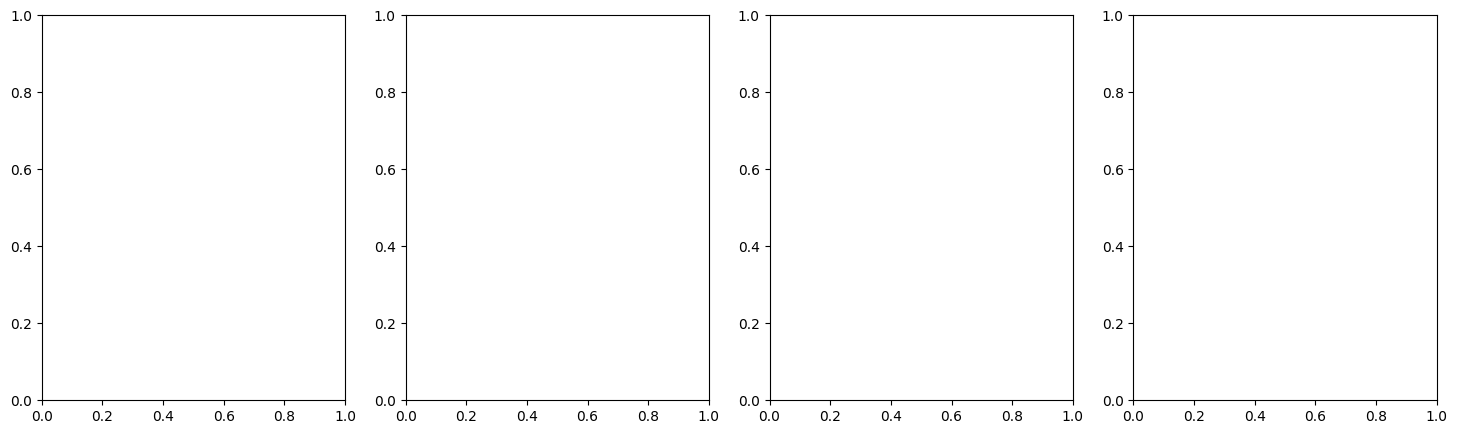

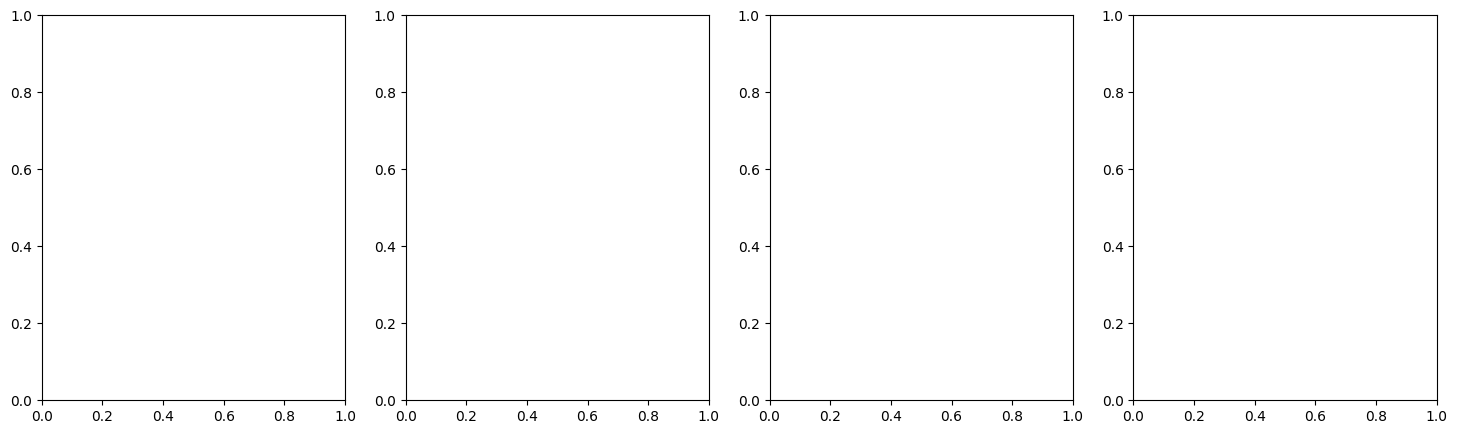

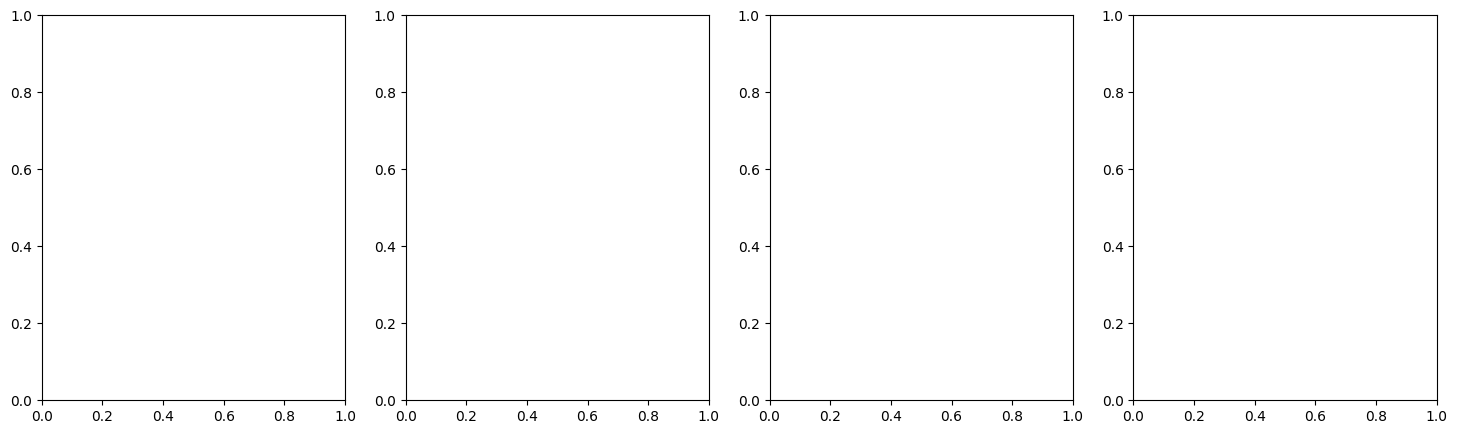

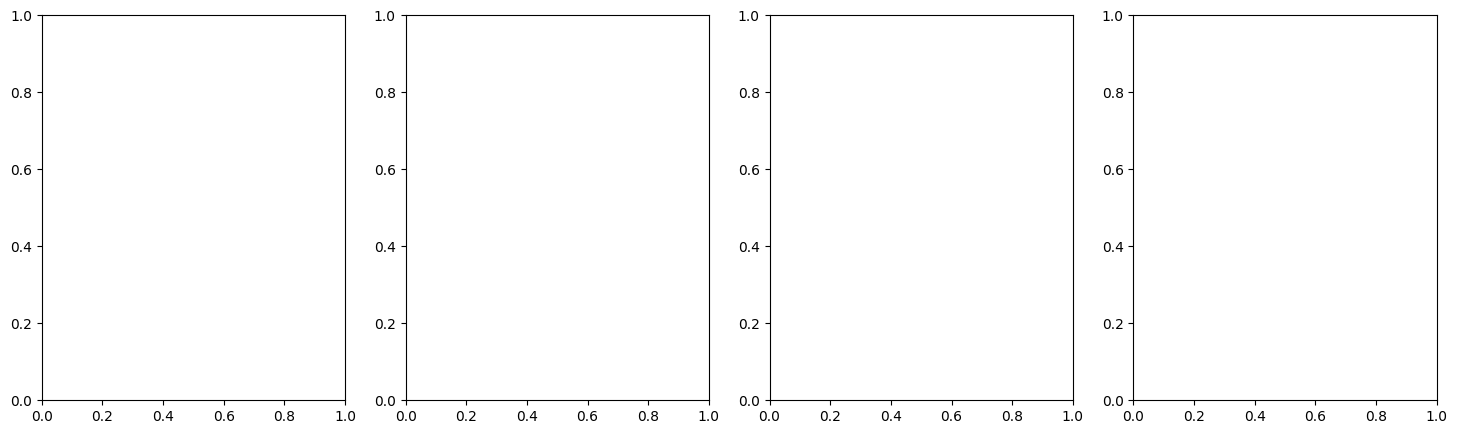

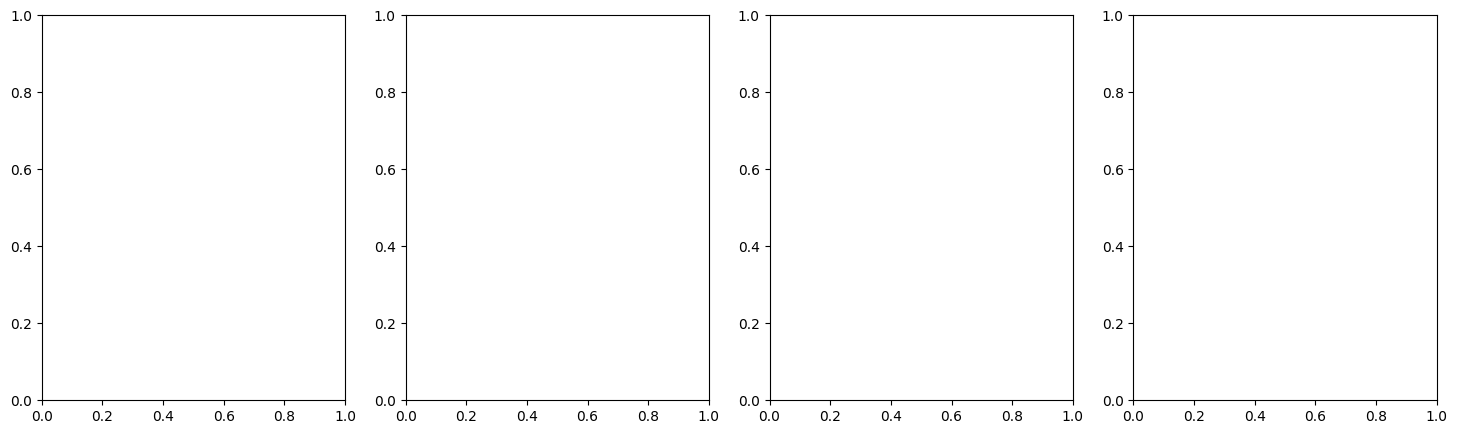

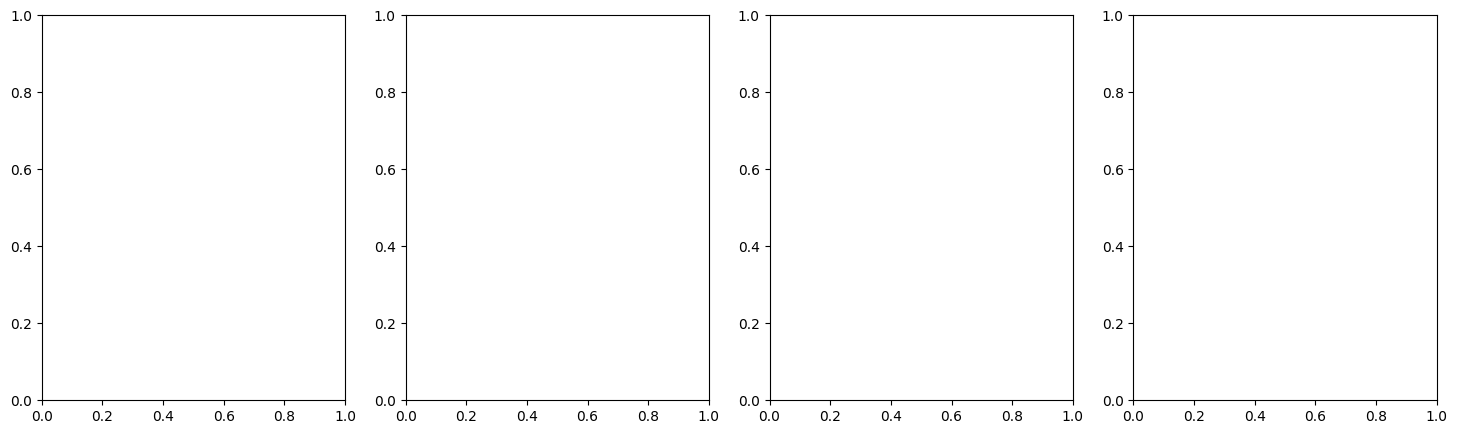

In [40]:

# 0 - predict 0
print("\n\nPredict - 0 hr")
for i in sets:
    print(i)
    predict_accessibility_from_timepoint(res_train = beds250_m0[i], res_test=beds250_m0[i], t1=0, t2=0, main_title = i+" - train: 0 days - test: 0 days", graphs=False)

# 0 - predict 4
print("\n\nPredict - 4 days")
for i in sets:
    print(i)
    predict_accessibility_from_timepoint(res_train = beds250_m0[i], res_test=beds250_m4[i], t1=0, t2=4, main_title = i+" - train: 0 days - test: 4 days", graphs=False)

# 0 - predict 8
print("\n\nPredict - 8 days")
for i in sets:
    print(i)
    predict_accessibility_from_timepoint(res_train = beds250_m0[i], res_test=beds250_m8[i], t1=0, t2=8, main_title = i+" - train: 0 days - test: 8 days", graphs=False)

### Trained on 4 day



Predict - 0 hr
enhancer
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.7064	0.703	0.7032	0.8173
R-squared:	0.176	0.1799	0.1797	0.0466
Pearson's r:	0.4839	0.5105	0.5443	0.41
Spearman's r:	0.3807	0.4192	0.486	0.415
promoter
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.6844	0.6867	0.6833	0.8791
R-squared:	0.6634	0.6623	0.664	0.5677
Pearson's r:	0.8312	0.8336	0.8378	0.7725
Spearman's r:	0.8191	0.8254	0.8372	0.7705


Predict - 4 days
enhancer
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.5728	0.5348	0.4889	0.6577
R-squared:	0.339	0.3828	0.4358	0.2411
Pearson's r:	0.583	0.6194	0.6608	0.4912
Spearman's r:	0.4612	0.5085	0.5745	0.4836
promoter
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.7246	0.7023	0.6701	0.9976
R-squared:	0.7398	0.7478	0.7594	0.6418
Pearson's r:	0.8603	0.8649	0.8717	0.8012
Spearman's r:	0.8481	0.8587	0.8706	0.7933


Predict - 8 days
enhancer
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.707	0.6599	0.6063	0.7607
R-squared:	0.2694	0.3181	0.3735	0.214
Pearson's r:	0.5282

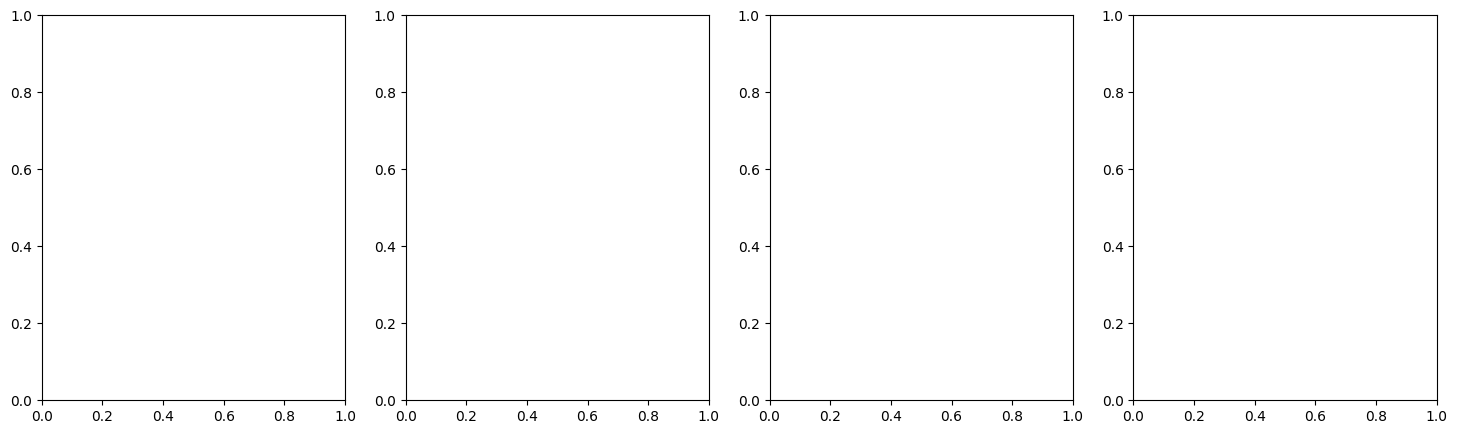

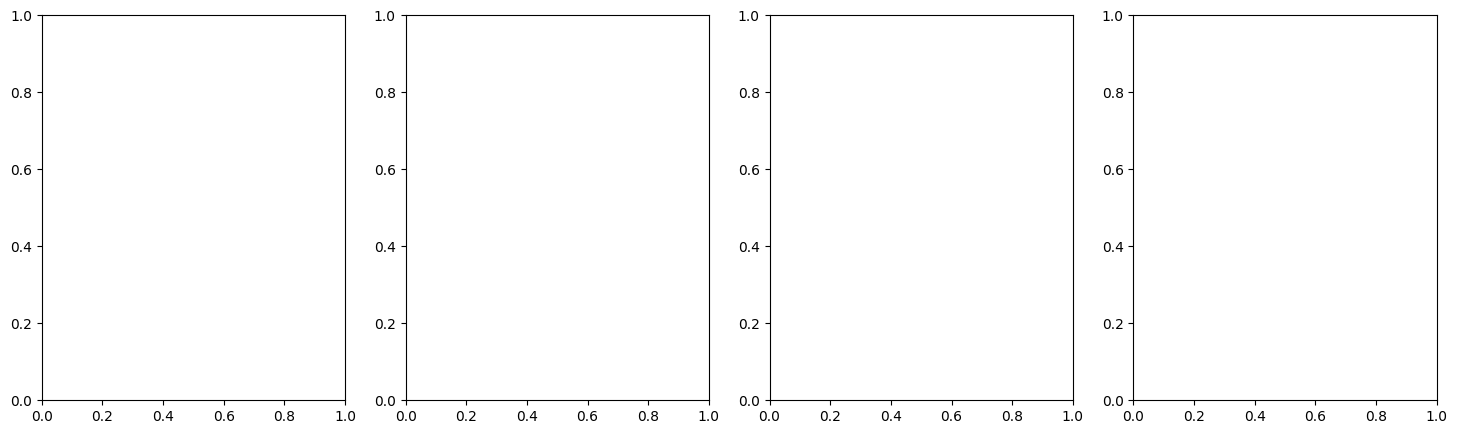

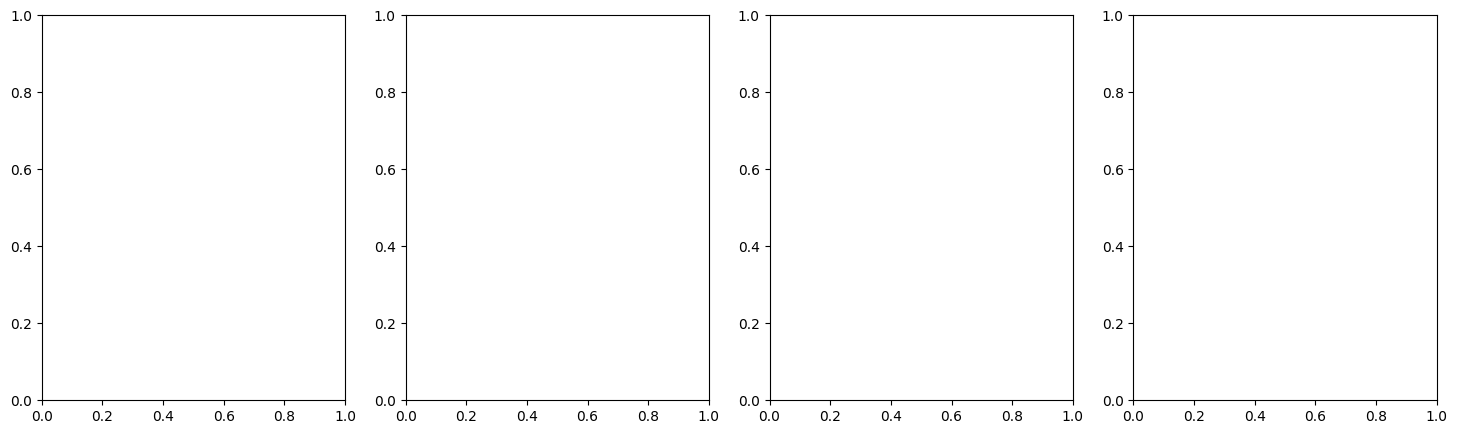

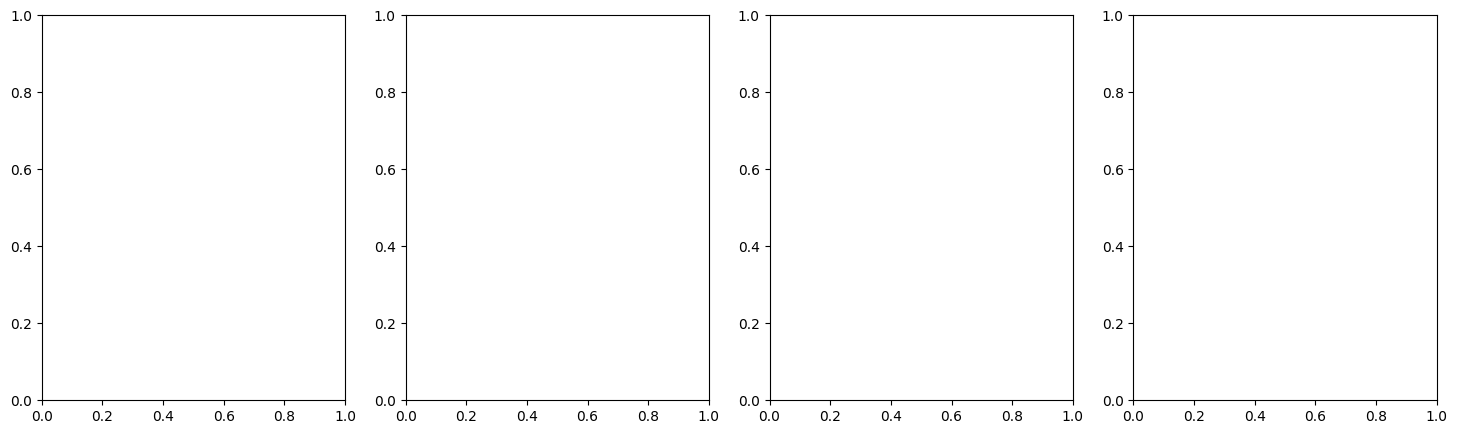

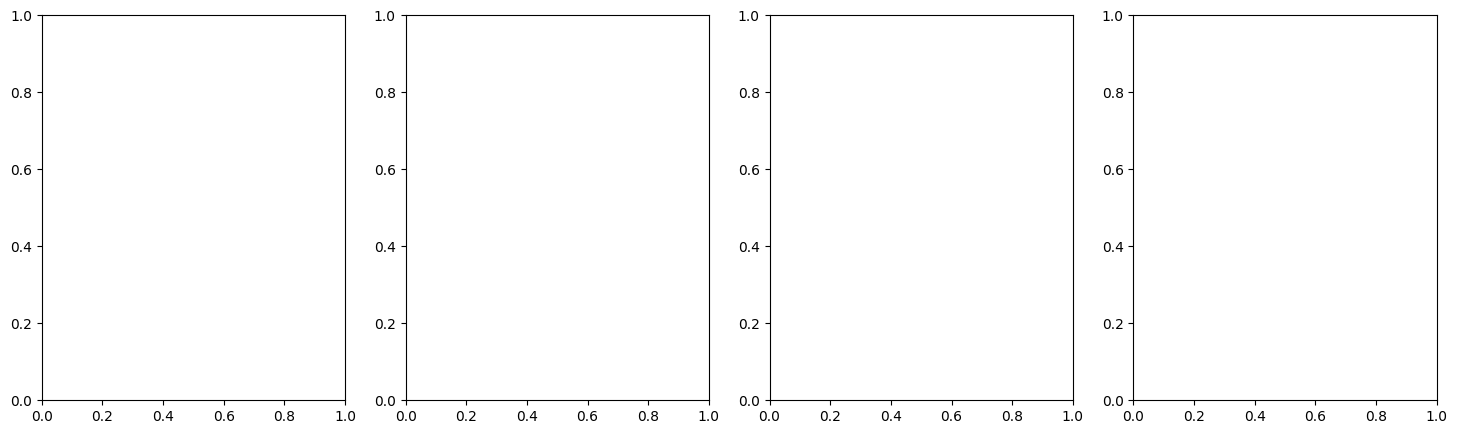

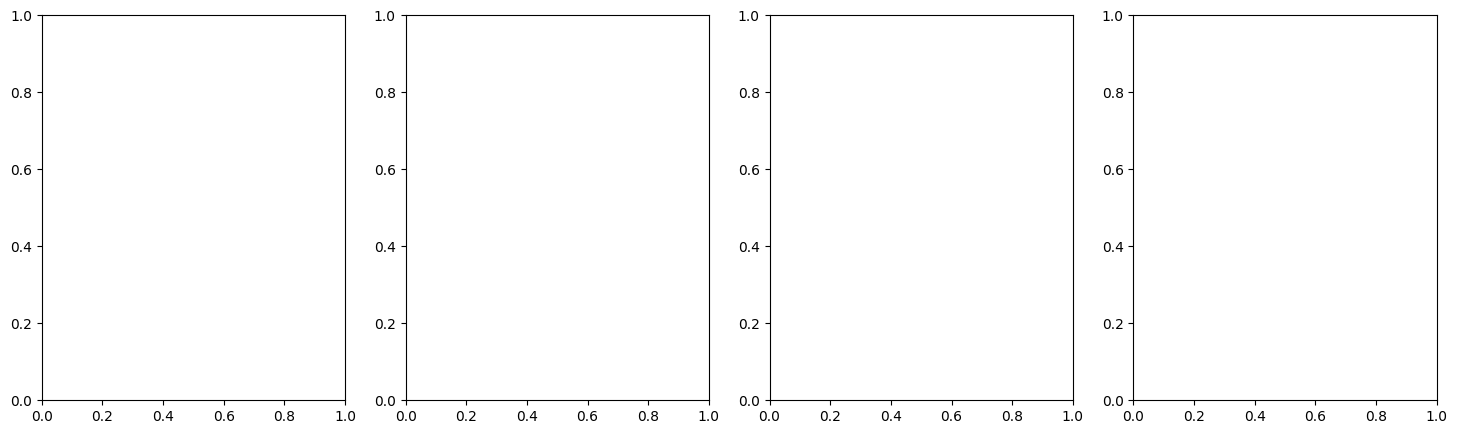

In [41]:
# 4 - predict 0
print("\n\nPredict - 0 hr")
for i in sets:
    print(i)
    predict_accessibility_from_timepoint(res_train = beds250_m4[i], res_test=beds250_m0[i], t1=4, t2=0, main_title = i+" - train: 4 days - test: 0 days", graphs=False)

# 4 - predict 4
print("\n\nPredict - 4 days")
for i in sets:
    print(i)
    predict_accessibility_from_timepoint(res_train = beds250_m4[i], res_test=beds250_m4[i], t1=4, t2=4, main_title = i+" - train: 4 days - test: 4 days", graphs=False)

# 4 - predict 8
print("\n\nPredict - 8 days")
for i in sets:
    print(i)
    predict_accessibility_from_timepoint(res_train = beds250_m4[i], res_test=beds250_m8[i], t1=4, t2=8, main_title = i+" - train: 4 days - test: 8 days", graphs=False)

### Trained on 8 day



Predict - 0 hr
enhancer
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.7559	0.7712	0.7905	0.8841
R-squared:	0.1182	0.1004	0.0779	-0.0313
Pearson's r:	0.4926	0.5178	0.5518	0.4238
Spearman's r:	0.3899	0.4311	0.4974	0.4277
promoter
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.757	0.7684	0.7779	0.9517
R-squared:	0.6277	0.6221	0.6174	0.532
Pearson's r:	0.828	0.8316	0.8354	0.7703
Spearman's r:	0.8135	0.823	0.8371	0.7687


Predict - 4 days
enhancer
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.5861	0.5481	0.5066	0.6672
R-squared:	0.3236	0.3675	0.4153	0.2301
Pearson's r:	0.5789	0.6152	0.6566	0.4916
Spearman's r:	0.4437	0.4921	0.5642	0.4804
promoter
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.7288	0.7133	0.6856	0.975
R-squared:	0.7383	0.7439	0.7538	0.6499
Pearson's r:	0.8624	0.8657	0.8716	0.8083
Spearman's r:	0.8444	0.8545	0.867	0.7959


Predict - 8 days
enhancer
Results for:	modC	mC	mC+hmC	hmc
Mean Sq Err:	0.6944	0.6471	0.5922	0.7493
R-squared:	0.2825	0.3314	0.3881	0.2258
Pearson's r:	

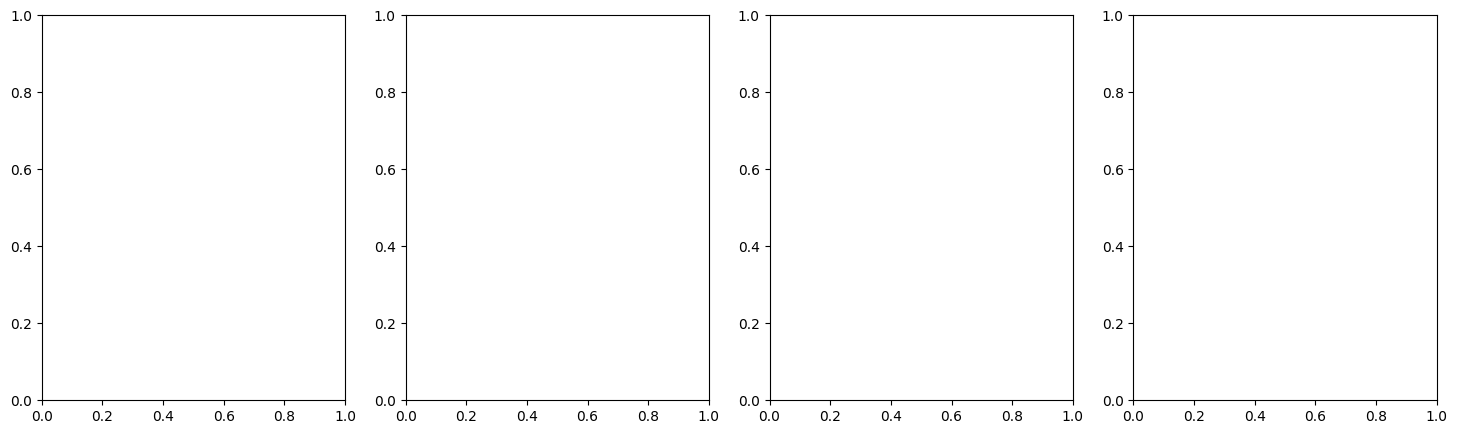

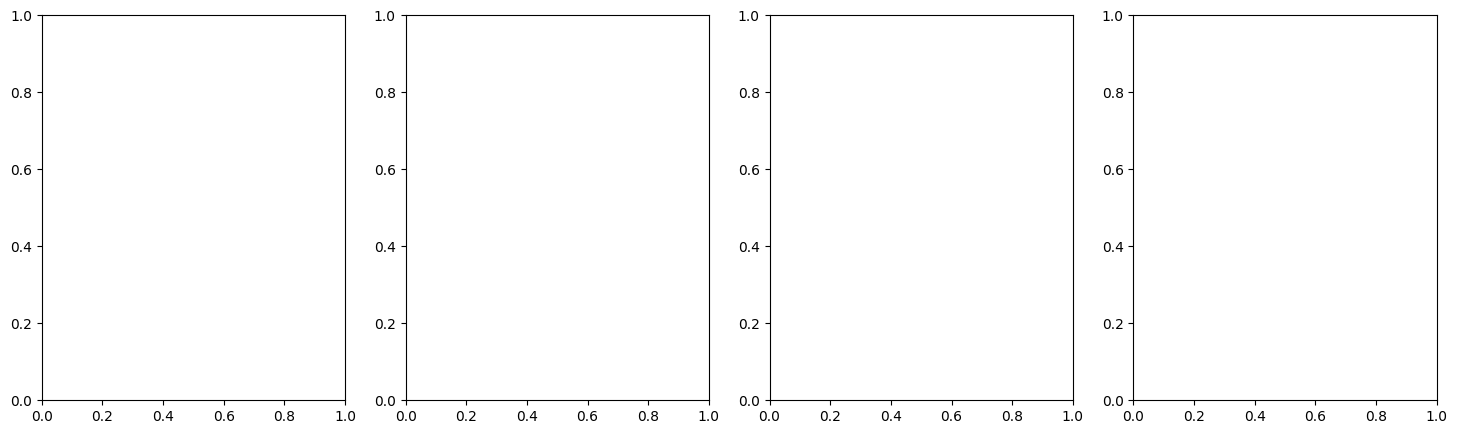

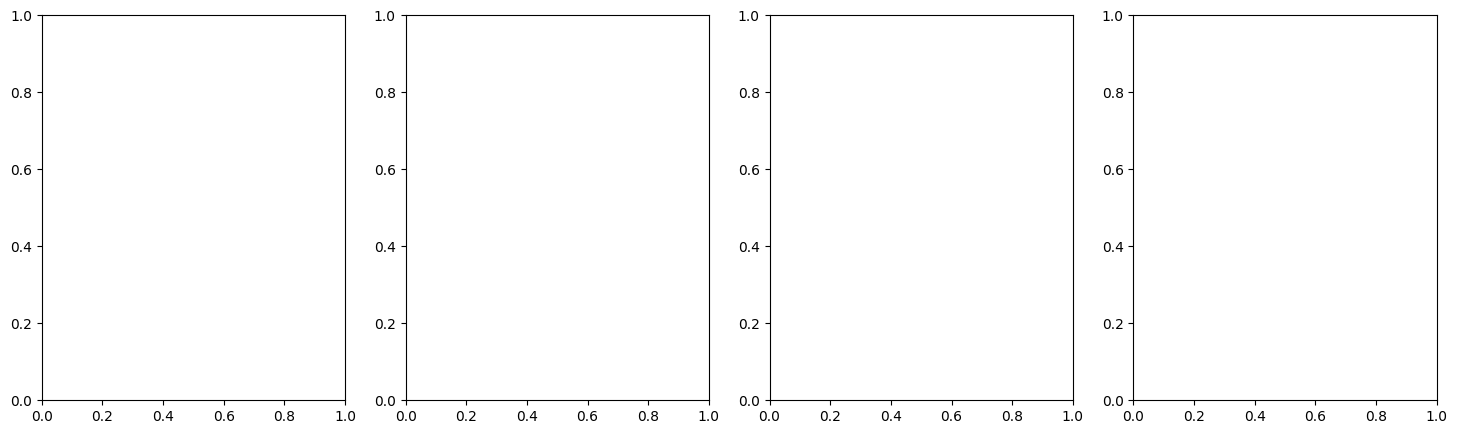

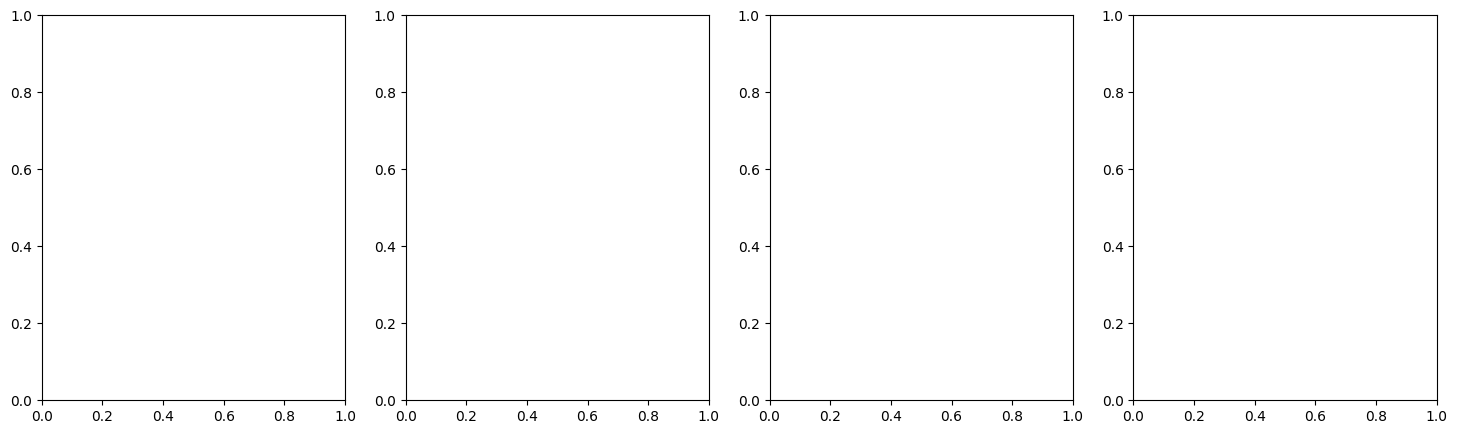

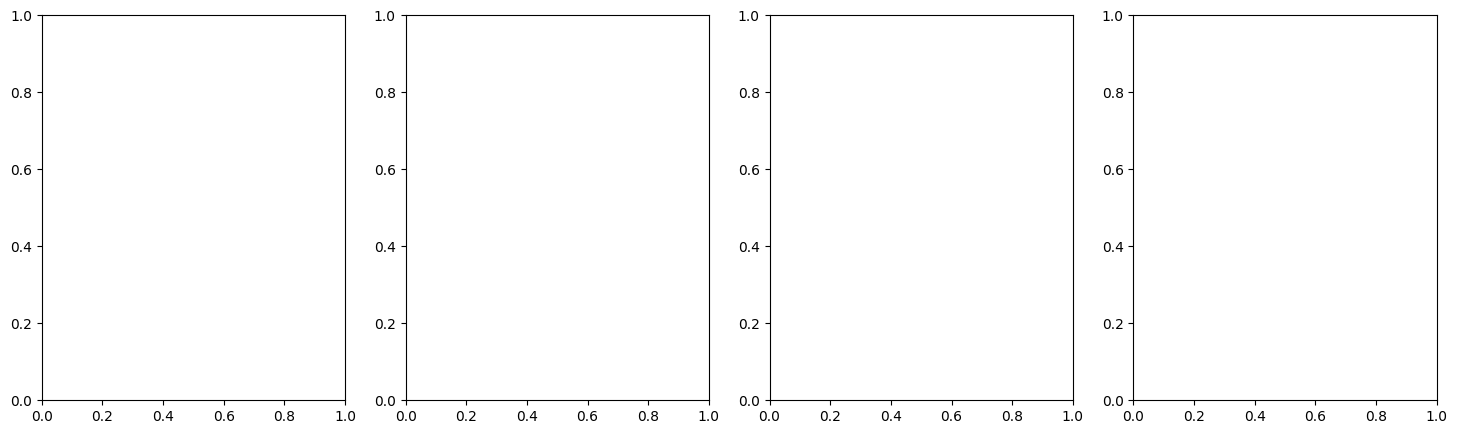

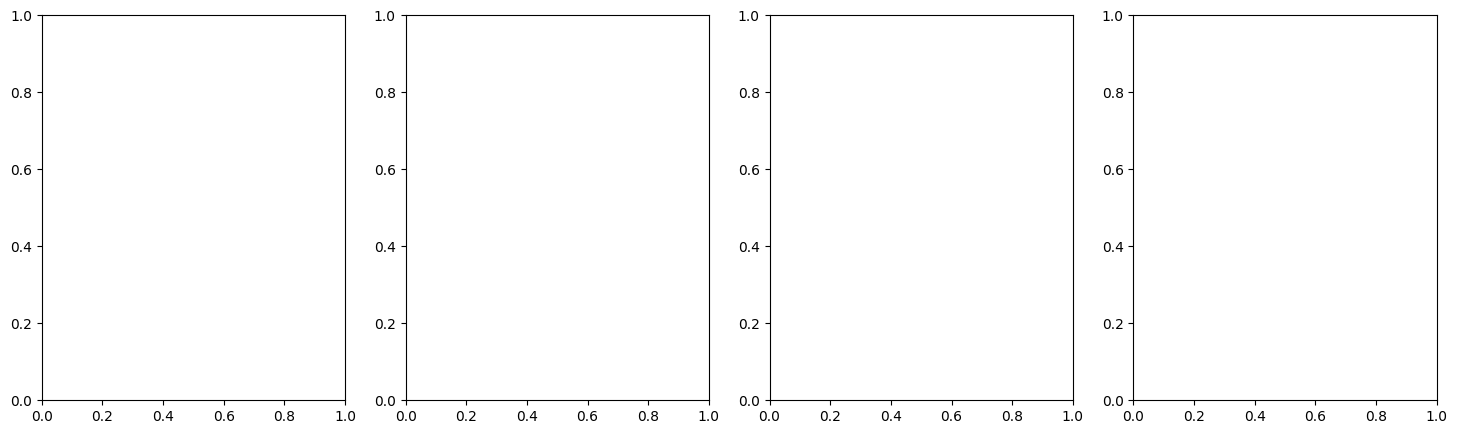

In [42]:
# 8 - predict 0
print("\n\nPredict - 0 hr")
for i in sets:
    print(i)
    predict_accessibility_from_timepoint(res_train = beds250_m8[i], res_test=beds250_m0[i], t1=8, t2=0, main_title = i+" - train: 8 days - test: 0 days", graphs=False)

# 8 - predict 4
print("\n\nPredict - 4 days")
for i in sets:
    print(i)
    predict_accessibility_from_timepoint(res_train = beds250_m8[i], res_test=beds250_m4[i], t1=8, t2=4, main_title = i+" - train: 8 days - test: 4 days", graphs=False)

# 8 - predict 8
print("\n\nPredict - 8 days")
for i in sets:
    print(i)
    predict_accessibility_from_timepoint(res_train = beds250_m8[i], res_test=beds250_m8[i], t1=8, t2=8, main_title = i+" - train: 8 days - test: 8 days", graphs=False)

### Spears saving

#### One run

In [23]:
spears

{'mc_00': ['0.439', '0.8254'],
 'mchmc_00': ['0.5073', '0.8408'],
 'hmc_00': ['0.4426', '0.7769'],
 'mc_04': ['0.4895', '0.8542'],
 'mchmc_04': ['0.549', '0.8609'],
 'hmc_04': ['0.4609', '0.785'],
 'mc_08': ['0.4705', '0.8456'],
 'mchmc_08': ['0.53', '0.8591'],
 'hmc_08': ['0.4448', '0.7919'],
 'mc_40': ['0.4192', '0.8254'],
 'mchmc_40': ['0.486', '0.8372'],
 'hmc_40': ['0.415', '0.7705'],
 'mc_44': ['0.5085', '0.8587'],
 'mchmc_44': ['0.5745', '0.8706'],
 'hmc_44': ['0.4836', '0.7933'],
 'mc_48': ['0.469', '0.8491'],
 'mchmc_48': ['0.5395', '0.8644'],
 'hmc_48': ['0.4579', '0.7977'],
 'mc_80': ['0.4311', '0.823'],
 'mchmc_80': ['0.4974', '0.8371'],
 'hmc_80': ['0.4277', '0.7687'],
 'mc_84': ['0.4921', '0.8545'],
 'mchmc_84': ['0.5642', '0.867'],
 'hmc_84': ['0.4804', '0.7959'],
 'mc_88': ['0.4755', '0.8465'],
 'mchmc_88': ['0.5412', '0.8617'],
 'hmc_88': ['0.4569', '0.7944']}

In [24]:
print(spears)

{'mc_00': ['0.439', '0.8254'], 'mchmc_00': ['0.5073', '0.8408'], 'hmc_00': ['0.4426', '0.7769'], 'mc_04': ['0.4895', '0.8542'], 'mchmc_04': ['0.549', '0.8609'], 'hmc_04': ['0.4609', '0.785'], 'mc_08': ['0.4705', '0.8456'], 'mchmc_08': ['0.53', '0.8591'], 'hmc_08': ['0.4448', '0.7919'], 'mc_40': ['0.4192', '0.8254'], 'mchmc_40': ['0.486', '0.8372'], 'hmc_40': ['0.415', '0.7705'], 'mc_44': ['0.5085', '0.8587'], 'mchmc_44': ['0.5745', '0.8706'], 'hmc_44': ['0.4836', '0.7933'], 'mc_48': ['0.469', '0.8491'], 'mchmc_48': ['0.5395', '0.8644'], 'hmc_48': ['0.4579', '0.7977'], 'mc_80': ['0.4311', '0.823'], 'mchmc_80': ['0.4974', '0.8371'], 'hmc_80': ['0.4277', '0.7687'], 'mc_84': ['0.4921', '0.8545'], 'mchmc_84': ['0.5642', '0.867'], 'hmc_84': ['0.4804', '0.7959'], 'mc_88': ['0.4755', '0.8465'], 'mchmc_88': ['0.5412', '0.8617'], 'hmc_88': ['0.4569', '0.7944']}


In [25]:
# Save
np.save('/data/hodges_lab/Tim/biomodal/data/spears.enhancer_vs_promoter.xtimepoint.mc_mchmc_hmc.npy', spears) 


In [ ]:

# Load
read_dictionary = np.load('my_file.npy',allow_pickle='TRUE').item()
print(read_dictionary['hello']) # displays "world"

#### Rerun - test/train on Chr1

In [43]:
spears

{'mc_00': ['0.439', '0.8254'],
 'mchmc_00': ['0.5073', '0.8408'],
 'hmc_00': ['0.4426', '0.7769'],
 'mc_04': ['0.4895', '0.8542'],
 'mchmc_04': ['0.549', '0.8609'],
 'hmc_04': ['0.4609', '0.785'],
 'mc_08': ['0.4705', '0.8456'],
 'mchmc_08': ['0.53', '0.8591'],
 'hmc_08': ['0.4448', '0.7919'],
 'mc_40': ['0.4192', '0.8254'],
 'mchmc_40': ['0.486', '0.8372'],
 'hmc_40': ['0.415', '0.7705'],
 'mc_44': ['0.5085', '0.8587'],
 'mchmc_44': ['0.5745', '0.8706'],
 'hmc_44': ['0.4836', '0.7933'],
 'mc_48': ['0.469', '0.8491'],
 'mchmc_48': ['0.5395', '0.8644'],
 'hmc_48': ['0.4579', '0.7977'],
 'mc_80': ['0.4311', '0.823'],
 'mchmc_80': ['0.4974', '0.8371'],
 'hmc_80': ['0.4277', '0.7687'],
 'mc_84': ['0.4921', '0.8545'],
 'mchmc_84': ['0.5642', '0.867'],
 'hmc_84': ['0.4804', '0.7959'],
 'mc_88': ['0.4755', '0.8465'],
 'mchmc_88': ['0.5412', '0.8617'],
 'hmc_88': ['0.4569', '0.7944']}

##### Combine into ggplotable dataframe (melted format)

In [50]:
num_set_items=2

In [51]:
meth_list=['mc','mchmc','hmc']*9*num_set_items # Set * [0|4|8 * 0|4|8] * [# set items]

In [52]:
train_time=(((['0']*9)+(['4']*9)+(['8']*9))*num_set_items)

In [53]:
test_time=((((['0']*3)+(['4']*3)+(['8']*3))*3)*num_set_items)

In [54]:
labs=([sets[0]]*27) + ([sets[1]]*27)

In [55]:
print(len(meth_list))
print(len(train_time))
print(len(test_time))
print(len(labs))

54
54
54
54


In [56]:
spears_to_save=pd.DataFrame({
    'meth': meth_list,
    'train_time': train_time,
    'test_time': test_time,
    'set': labs,
    'spearman': pd.DataFrame.from_dict(spears, orient='index').melt().value
})

In [57]:
spears_to_save

,meth,train_time,test_time,set,spearman
0,mc,0,0,enhancer,0.439
1,mchmc,0,0,enhancer,0.5073
2,hmc,0,0,enhancer,0.4426
3,mc,0,4,enhancer,0.4895
4,mchmc,0,4,enhancer,0.549
5,hmc,0,4,enhancer,0.4609
6,mc,0,8,enhancer,0.4705
7,mchmc,0,8,enhancer,0.53
8,hmc,0,8,enhancer,0.4448
9,mc,4,0,enhancer,0.4192


##### Save

In [60]:
spears_to_save.to_csv('/data/hodges_lab/Tim/biomodal/data/spears.prediction_enhancer_vs_promoter.x_timepoint.for_simple_supplement_dotline_plots.long_form_melted.txt', sep="\t", index = None)

# Plots - R

## Libraries

In [1]:
library(ggplot2)
library(tidyverse)
library(RColorBrewer)
library(ggrepel)
library(data.table)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   1.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load data

In [2]:
# Load spearman dataframe
sdf <- read_tsv("/data/hodges_lab/Tim/biomodal/data/spears.prediction_enhancer_vs_promoter.x_timepoint.for_simple_supplement_dotline_plots.long_form_melted.txt", col_names=T) 
# Replace "sets" with "static"; python goof to fix
sdf <- sdf %>% mutate(across('set', str_replace, 'sets', 'static'))
sdf

Rows: 54 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): meth, set
dbl (3): train_time, test_time, spearman

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across("set", str_replace, "sets", "static")`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


meth,train_time,test_time,set,spearman
<chr>,<dbl>,<dbl>,<chr>,<dbl>
mc,0,0,enhancer,0.4390
mchmc,0,0,enhancer,0.5073
hmc,0,0,enhancer,0.4426
mc,0,4,enhancer,0.4895
mchmc,0,4,enhancer,0.5490
hmc,0,4,enhancer,0.4609
mc,0,8,enhancer,0.4705
mchmc,0,8,enhancer,0.5300
hmc,0,8,enhancer,0.4448


## ggplot

In [39]:
# font size 
lab_size=14
axislab_size=17
label_size=5
fig_h=10
fig_w=10

# plot size
options(repr.plot.width = fig_w, repr.plot.height = fig_h)

# colors
col_dict = c(
    "mc"="cadetblue1",
    "mchmc"="lightsalmon3",
    "hmc"="salmon1"
)


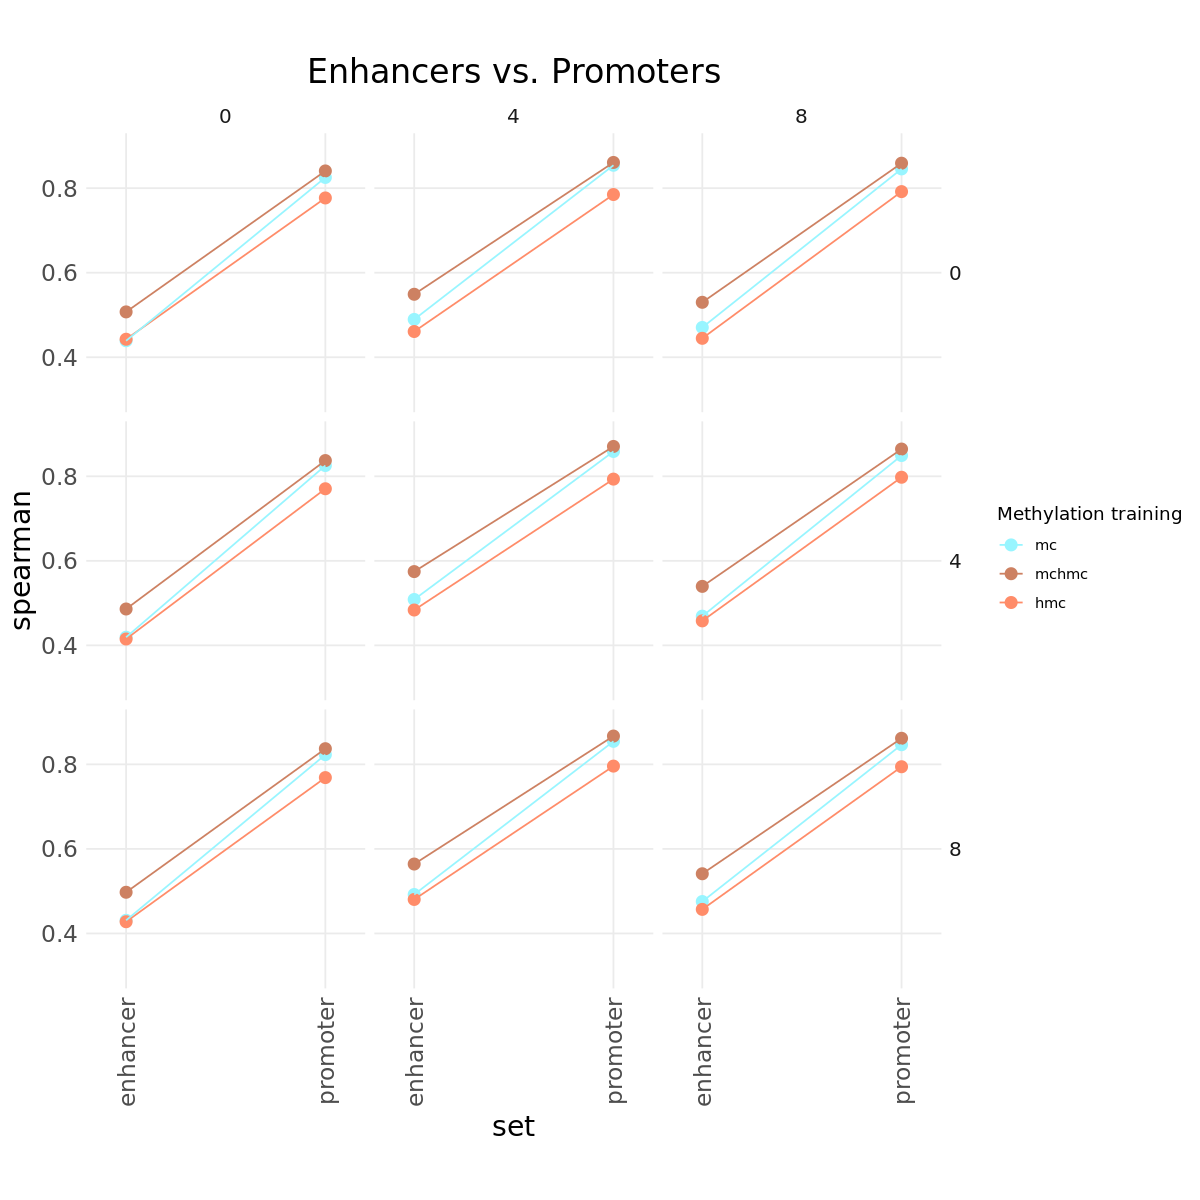

In [40]:
p <- sdf %>%
    ggplot(aes(x = set, y = spearman)) + # ggplot object
        # points
        geom_point(aes(color = meth), size = 3) +
        # lines
        geom_line(aes(color = meth, group = meth)) +
        # create 3x3 grid
        facet_grid(train_time ~ test_time) +
        # colors for points
        scale_color_manual("Methylation training", values = col_dict) + # set colors for meth
        # theme
        theme_minimal() +
        ggtitle("Enhancers vs. Promoters") + # plot title
        theme(
                aspect.ratio = 1,
                plot.title = element_text(hjust = 0.5, size = 20),
                strip.text.x = element_text(size = 12, hjust = .5, angle = 0), # facet_grid for cols
                strip.text.y = element_text(size = 12, hjust = 0, angle = 0), # facet_grid for rows
                axis.title.x = element_text(size = axislab_size), # axis title size
                axis.title.y = element_text(size = axislab_size), # axis title size
                axis.text.y = element_text(size = lab_size), # axis text label size 
                axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = lab_size), # axis text label size 
                #panel.grid.major = element_blank(),
                panel.grid.minor = element_blank() # labels on 0.4,0.6,0.8 so keeping minor
        )  +
        # remove extra white space between plotted data and sides of plot
        scale_x_discrete(limits = c('enhancer', 'promoter'), expand = c(0.1, .1)) +
        # set y-axis scale
        coord_cartesian(ylim = c(0.3, 0.9))

p

### Save

In [34]:
ggsave(filename = paste0("/data/hodges_lab/Tim/biomodal/enhancer_vs_promoter.mc_hmc_mchmc.x_timepoint.ggplot.pdf"), p, width = fig_w, height = fig_h, dpi = 150)

# plots

## split spears

In [27]:
spears_train0={k: spears[k] for k in list(spears)[:9]}
spears_train4={k: spears[k] for k in list(spears)[9:18]}
spears_train8={k: spears[k] for k in list(spears)[18:28]}

## line plots

In [41]:
def make_axes(spear_dict, train_time=0, filename_save='/data/hodges_lab/Tim/default_output_ml.png'):
    # sets=['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7']
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    y_min_val=-.2
    y_max_val=1


    # Lines
    axs[0].title.set_text('0 hr')
    axs[0].tick_params(labelrotation=45)
    line0_mc = axs[0].plot(sets, list(map(float, spear_dict['mc_'+str(train_time)+'0'])), 'lightskyblue', marker='^', label='mc_0hr')
    line0_mchmc = axs[0].plot(sets, list(map(float, spear_dict['mchmc_'+str(train_time)+'0'])), 'tomato', marker='o', label='mchmc_0hr')
    line0_hmc = axs[0].plot(sets, list(map(float, spear_dict['hmc_'+str(train_time)+'0'])), 'indigo', marker='s', label='hmc_0hr')

    axs[1].title.set_text('4 day')
    axs[1].tick_params(labelrotation=45)
    line4_mc = axs[1].plot(sets, list(map(float, spear_dict['mc_'+str(train_time)+'4'])), 'lightskyblue', marker='^',label='mc_4hr')
    line4_mchmc = axs[1].plot(sets, list(map(float, spear_dict['mchmc_'+str(train_time)+'4'])), 'tomato', marker='o',label='mchmc_4hr')
    line4_hmc = axs[1].plot(sets, list(map(float, spear_dict['hmc_'+str(train_time)+'4'])), 'indigo', marker='s',label='hmc_4hr')

    axs[2].title.set_text('8 day')
    axs[2].tick_params(labelrotation=45)
    line8_mc = axs[2].plot(sets, list(map(float, spear_dict['mc_'+str(train_time)+'8'])), 'lightskyblue', marker='^',label='mc_8hr')
    line8_mchmc = axs[2].plot(sets, list(map(float, spear_dict['mchmc_'+str(train_time)+'8'])), 'tomato', marker='o',label='mchmc_8hr')
    line8_hmc = axs[2].plot(sets, list(map(float, spear_dict['hmc_'+str(train_time)+'8'])), 'indigo', marker='s',label='hmc_8hr')


    # Labels for lines
    lines = line0_mc+line4_mc+line8_mc+line0_mchmc+line4_mchmc+line8_mchmc+line0_hmc+line4_hmc+line8_hmc
    labels = [l.get_label() for l in lines]
    plt.legend(lines,labels,loc='center right', prop={'size':10}, bbox_to_anchor=(0.5, -0.13), fancybox=False, shadow=False, ncol=5)


    # Horizontal lines 
    # mpl.pyplot.hlines([np.arange(0.5, 1, 0.2)], xmin='random_3817', xmax='random_10000_3', linestyles= "dashed", colors='palevioletred', linewidth=0.5)
    # mpl.pyplot.hlines([np.arange(0.6, 1.1, 0.2)], xmin='random_3817', xmax='random_10000_3', linestyles= "dashed", colors='gainsboro', linewidth=0.5)


    # Set y-axis range
    for i in range(3):
        axs[i].set_ylim(y_min_val, y_max_val)
        axs[i].hlines([np.arange(y_min_val, y_max_val, 0.2)], xmin=sets[0], xmax=sets[len(sets)-1], linestyles= "dashed", colors='palevioletred', linewidth=0.5)
        axs[i].hlines([np.arange(y_min_val+0.1, y_max_val+0.1, 0.2)], xmin=sets[0], xmax=sets[len(sets)-1], linestyles= "dashed", colors='lightgray', linewidth=0.5)

    # Axis labels and ticks
    for ax in axs.flat:
        ax.set(xlabel='Clusters')
        ax.set(ylabel='SpearmanR')
        ax.set_yticks(np.arange(y_min_val, y_max_val, 0.1))

    plt.savefig(filename_save, bbox_inches='tight', dpi = 150)

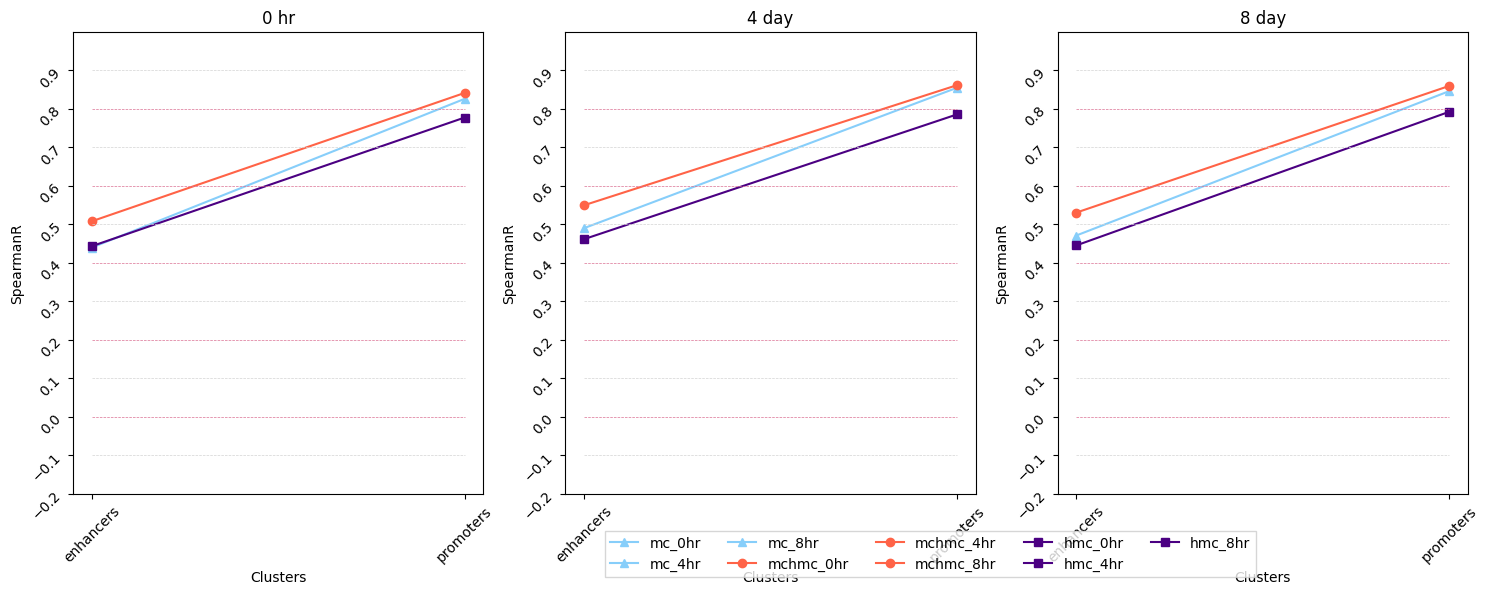

In [42]:
make_axes(spears_train0, train_time=0, filename_save='/data/hodges_lab/Tim/biomodal/plots/Prediction.mc_mchmc_hmc.enhancer_vs_promoter.train0.png')

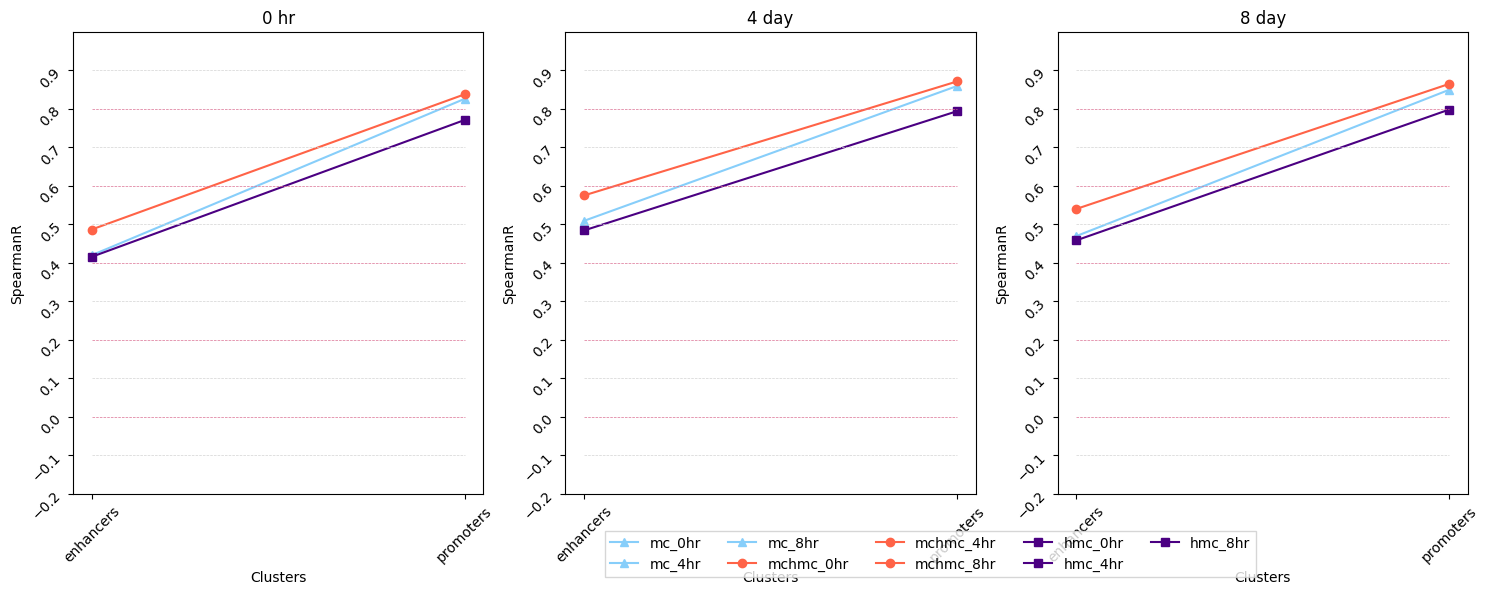

In [45]:
make_axes(spears_train4, train_time=4, filename_save='/data/hodges_lab/Tim/biomodal/plots/Prediction.mc_mchmc_hmc.enhancer_vs_promoter.train4.png')

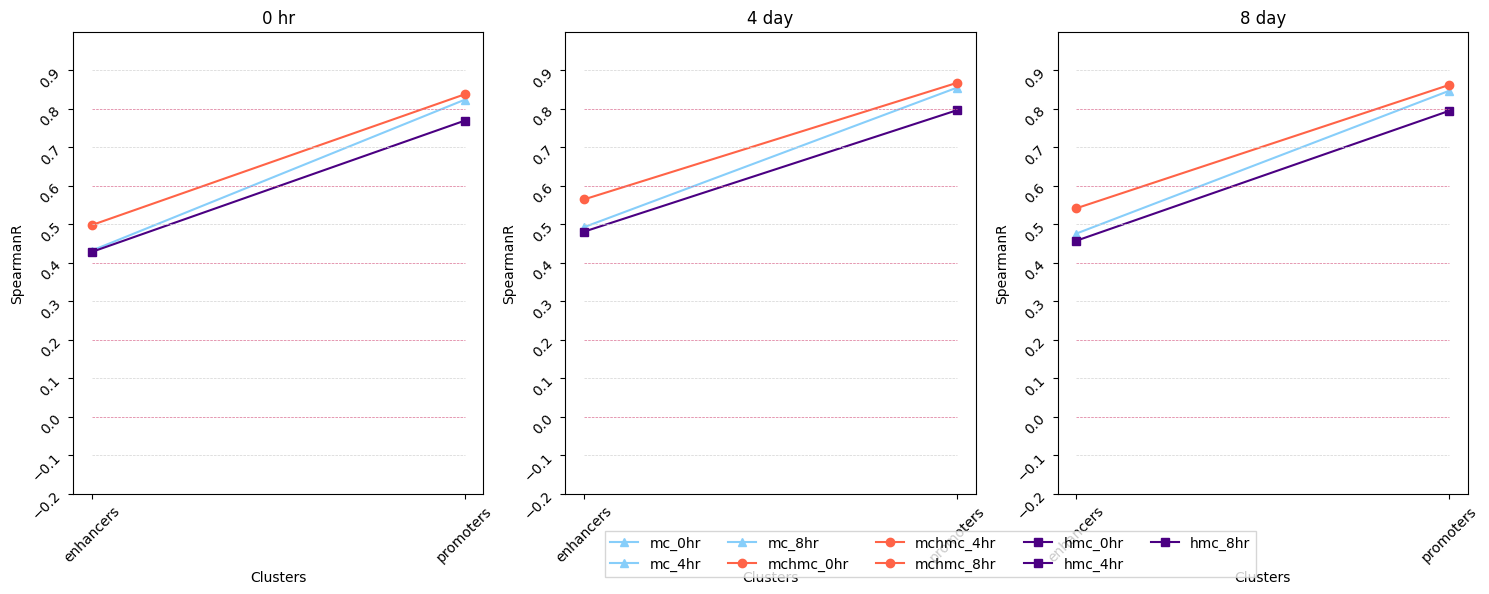

In [46]:
make_axes(spears_train8, train_time=8, filename_save='/data/hodges_lab/Tim/biomodal/plots/Prediction.mc_mchmc_hmc.enhancer_vs_promoter.train8.png')

In [47]:
spears_train0

{'mc_00': ['0.439', '0.8254'],
 'mchmc_00': ['0.5073', '0.8408'],
 'hmc_00': ['0.4426', '0.7769'],
 'mc_04': ['0.4895', '0.8542'],
 'mchmc_04': ['0.549', '0.8609'],
 'hmc_04': ['0.4609', '0.785'],
 'mc_08': ['0.4705', '0.8456'],
 'mchmc_08': ['0.53', '0.8591'],
 'hmc_08': ['0.4448', '0.7919']}

In [48]:
spears_train4

{'mc_40': ['0.4192', '0.8254'],
 'mchmc_40': ['0.486', '0.8372'],
 'hmc_40': ['0.415', '0.7705'],
 'mc_44': ['0.5085', '0.8587'],
 'mchmc_44': ['0.5745', '0.8706'],
 'hmc_44': ['0.4836', '0.7933'],
 'mc_48': ['0.469', '0.8491'],
 'mchmc_48': ['0.5395', '0.8644'],
 'hmc_48': ['0.4579', '0.7977']}

In [49]:
spears_train8

{'mc_80': ['0.4311', '0.823'],
 'mchmc_80': ['0.4974', '0.8371'],
 'hmc_80': ['0.4277', '0.7687'],
 'mc_84': ['0.4921', '0.8545'],
 'mchmc_84': ['0.5642', '0.867'],
 'hmc_84': ['0.4804', '0.7959'],
 'mc_88': ['0.4755', '0.8465'],
 'mchmc_88': ['0.5412', '0.8617'],
 'hmc_88': ['0.4569', '0.7944']}